In [1]:
from time import time   

import json
import os
import numpy as np  
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
    
import torch            
import torch.nn as nn

import torchvision      
import torchvision.transforms as transforms
import torchsummary     

from model import CNN
from utils import visualizer

In [2]:
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [3]:
with open("./config.json","r") as f:
    cfg = json.load(f)

gpu_id = cfg["gpu_id"]
model_state = cfg["model_state"]    

In [5]:
if gpu_id >= 0:
    if not torch.cuda.is_available():
       raise RuntimeError(f"GPU is not available.")
    else:
                torch.cuda.init()
    print(f"Running with GPU {gpu_id}.")
else:
    print(f"Running with CPU.")
device = torch.device(gpu_id if gpu_id >= 0 else "cpu")

Running with GPU 0.


In [6]:
model_state_path = os.path.join("./workspace/checkpoint", model_state)

model = CNN().to(device).cuda() 
model.load_state_dict(torch.load(model_state_path))
model.eval()

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (l1): Linear(in_features=1568, out_features=1024, bias=True)
  (l2): Linear(in_features=1024, out_features=1024, bias=True)
  (l3): Linear(in_features=1024, out_features=10, bias=True)
  (act): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [7]:
test_data = torchvision.datasets.MNIST(root="./", train=False, transform=transforms.ToTensor(), download=True)
print(type(test_data.data), type(test_data.targets))
print(test_data.data.size(), test_data.targets.size())

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([10000, 28, 28]) torch.Size([10000])


test accuracy: 0.9916


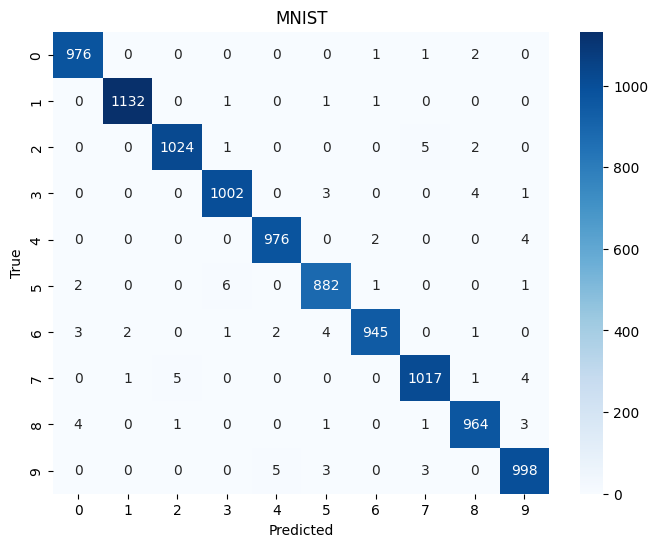

In [8]:
test_loader = torch.utils.data.DataLoader(test_data, batch_size=100, shuffle=False)

all_preds = []
all_labels = []

# 評価の実行
correct_count = 0
with torch.no_grad():  # 勾配を計算しない設定
    for image, label in test_loader:
        if gpu_id >= 0:
            image = image.cuda()
            label = label.cuda()
            
        y = model(image)

        # 予測ラベルを計算
        pred = torch.argmax(y, dim=1)
        correct_count += torch.sum(pred == label)

        all_preds.append(pred.cpu().numpy())
        all_labels.append(label.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
        
print("test accuracy: {:.4f}".format(correct_count.item() / len(test_loader.dataset)))

visualizer.mk_confusion_matrix(class_names, all_labels, all_preds)